<a href="https://colab.research.google.com/github/ShobitKapila/Acoustic-source-identification/blob/main/wind_turbin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature extraction for sound data often involves using signal processing libraries like librosa, extracting features such as Mel-frequency cepstral coefficients (MFCCs), spectral features, or others.

For finding the best threshold value for wind turbin generator - Plotting the precision-recall curve can help visualize the trade-off between precision and recall at different thresholds.

In [ ]:
import os
import numpy as np
import librosa
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import joblib

# data pre-processing in batch size to resolve the memory allocation error
def load_data(folder_path, batch_size=10):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".mat"):
            file_path = os.path.join(folder_path, file_name)
            try:
                mat_data = loadmat(file_path)
                mat_version = mat_data['__version__']
                print(f'MATLAB file version: {mat_version}')
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                continue

            for key in mat_data.keys():
                if key.startswith('AN'):
                    sample_data = mat_data[key]
                    num_samples = sample_data.shape[0]

                    num_batches = (num_samples + batch_size - 1) // batch_size

                    for i in range(0, num_batches):
                        start_idx = i * batch_size
                        end_idx = min((i + 1) * batch_size, num_samples)
                        yield sample_data[start_idx:end_idx], mat_data['Speed'][start_idx:end_idx]

# feature extraction
def extract_features_from_sound(sound_file_path):
    y, sr = librosa.load(sound_file_path)
    features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return features.T

# training the dataset with test set
def train_and_evaluate(X, y, save_model_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

    desired_precision = 0.8
    desired_recall = 0.8

    closest_precision_idx = np.argmax(precision >= desired_precision)
    closest_recall_idx = np.argmax(recall >= desired_recall)

    best_threshold = (thresholds[closest_precision_idx] + thresholds[closest_recall_idx]) / 2
    print(f"Best Threshold: {best_threshold}")

    y_pred = (y_pred_proba > best_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    f1_acc = f1_score(y_test, y_pred)
    print(f"F1 Accuracy Score: {f1_acc}")

    joblib.dump(clf, save_model_path)
    print(f"Model saved to {save_model_path}")

# data processing and training
def process_data_and_train(folder_path, save_model_path):
    data_generator = load_data(folder_path)
    X_chunks, y_chunks = zip(*data_generator)

    X = np.concatenate(X_chunks, axis=0)
    y = np.concatenate(y_chunks, axis=0)

    train_and_evaluate(X, y, save_model_path)

healthy_folder_path = "C:/Users/Shobit/PycharmProjects/ASI_detection/Healthy"
damaged_folder_path = "C:/Users/Shobit/PycharmProjects/ASI_detection/Damaged"

healthy_model_path = "D:/wind turbin/healthy_model.joblib"
damaged_model_path = "D:/wind turbin/damaged_model.joblib"

print("Healthy Dataset:")
process_data_and_train(healthy_folder_path, healthy_model_path)

print("\nDamaged Dataset:")
process_data_and_train(damaged_folder_path, damaged_model_path)

# driver code
sound_file_path = "C:/Users/Shobit/PycharmProjects/ASI_detection/Healthy_turbin.mp3"
sound_features = extract_features_from_sound(sound_file_path)
model = joblib.load(healthy_model_path)
prediction = model.predict(sound_features.reshape(1, -1))
print(f"The predicted healthiness is: {'Damaged' if prediction == 1 else 'Healthy'}")


Healthy Dataset:
MATLAB file version: 1.0
MATLAB file version: 1.0
MATLAB file version: 1.0
MATLAB file version: 1.0
MATLAB file version: 1.0
MATLAB file version: 1.0
MATLAB file version: 1.0
MATLAB file version: 1.0
MATLAB file version: 1.0
MATLAB file version: 1.0


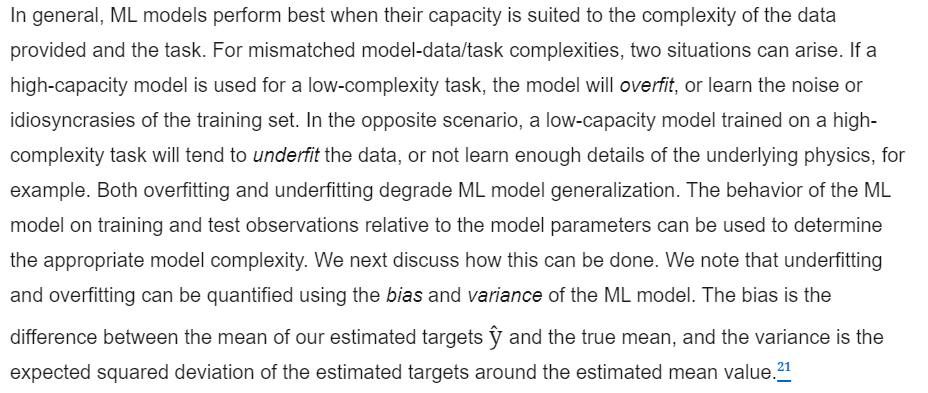

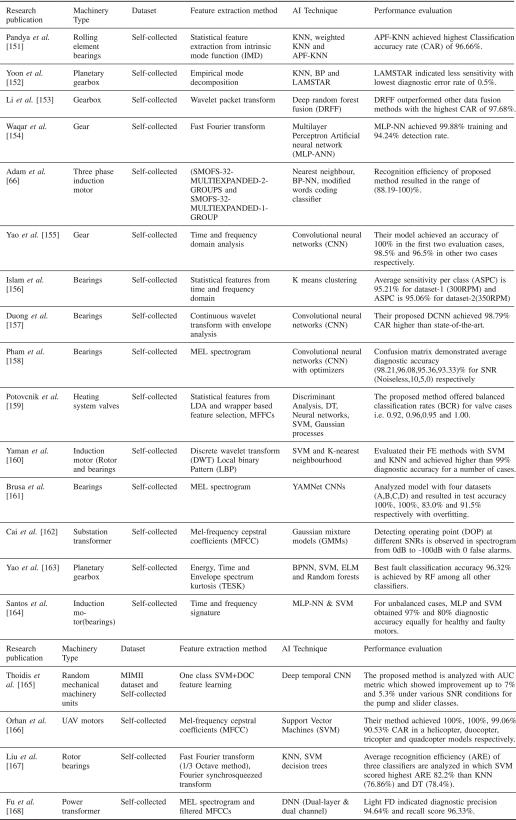

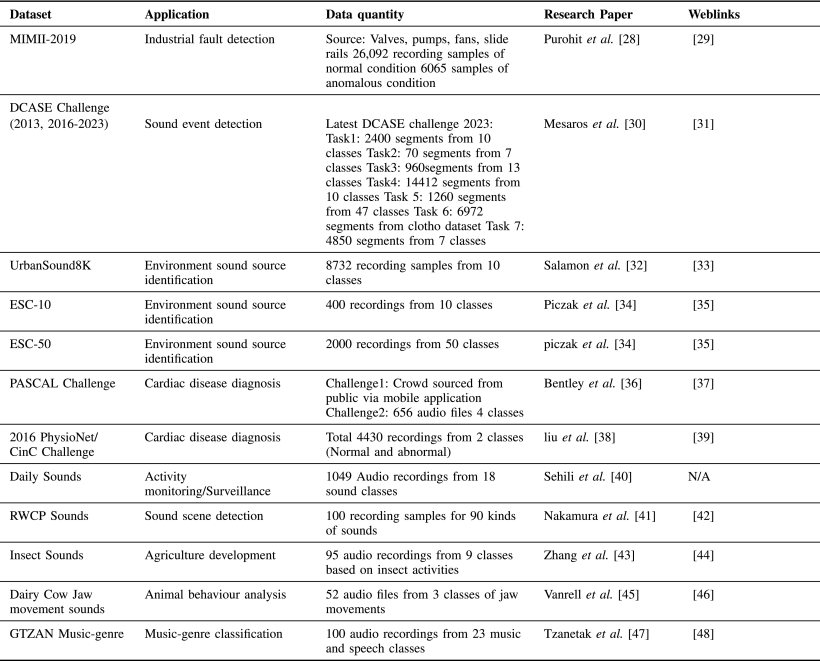